In [1]:
# ! pip install -q tensorflow-probability

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf

In [2]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [3]:
def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [4]:
def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(28, 28, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()

2023-07-17 01:48:01.129341: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-07-17 01:48:01.129367: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-07-17 01:48:01.129374: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-07-17 01:48:01.129409: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-17 01:48:01.129424: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 16)          19856     
                                                                 
 vector_quantizer (VectorQu  (None, 7, 7, 16)          1024      
 antizer)                                                        
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         28033     
                                                                 
Total params: 48913 (191.07 KB)
Trainable params: 48913 (191.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

In [6]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

In [7]:
x_train_scaled.shape

(60000, 28, 28, 1)

In [8]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(x_train_scaled, epochs=30, batch_size=128)

Epoch 1/30


2023-07-17 01:48:07.694085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 14s 22ms/step - loss: 2.7389 - reconstruction_loss: 0.3604 - vqvae_loss: 2.0384
Epoch 2/30
469/469 [==============================] - 10s 22ms/step - loss: 1.9331 - reconstruction_loss: 0.1528 - vqvae_loss: 1.7668
Epoch 3/30
469/469 [==============================] - 10s 21ms/step - loss: 0.8653 - reconstruction_loss: 0.1199 - vqvae_loss: 0.7387
Epoch 4/30
469/469 [==============================] - 10s 22ms/step - loss: 0.5477 - reconstruction_loss: 0.0989 - vqvae_loss: 0.4450
Epoch 5/30
469/469 [==============================] - 11s 22ms/step - loss: 0.4346 - reconstruction_loss: 0.0870 - vqvae_loss: 0.3451
Epoch 6/30
469/469 [==============================] - 10s 21ms/step - loss: 0.3672 - reconstruction_loss: 0.0790 - vqvae_loss: 0.2864
Epoch 7/30
469/469 [==============================] - 10s 21ms/step - loss: 0.3281 - reconstruction_loss: 0.0731 - vqvae_loss: 0.2540
Epoch 8/30
469/469 [==============================] - 10s 21ms/step - los

2023-07-17 01:53:50.229677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 504ms/step


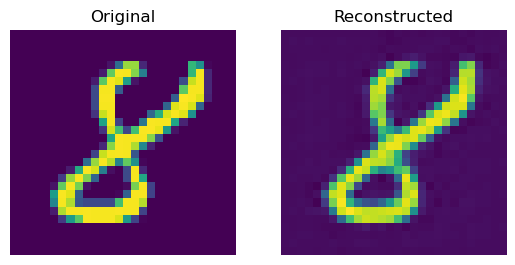

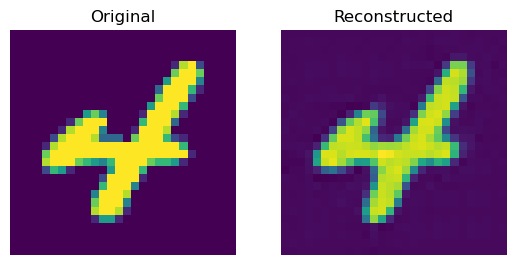

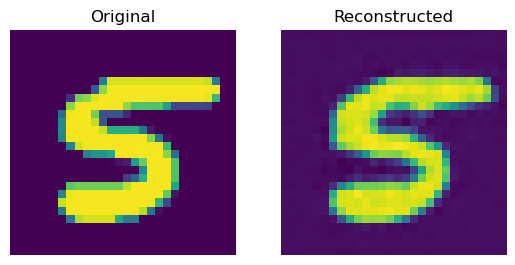

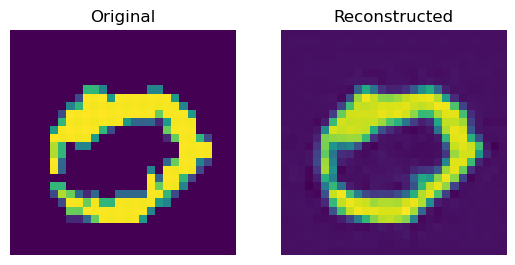

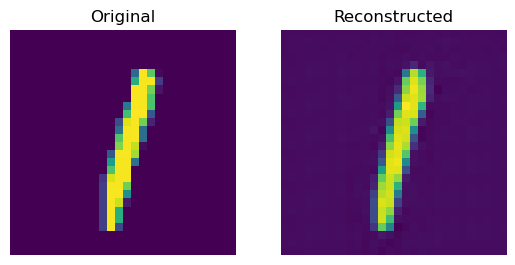

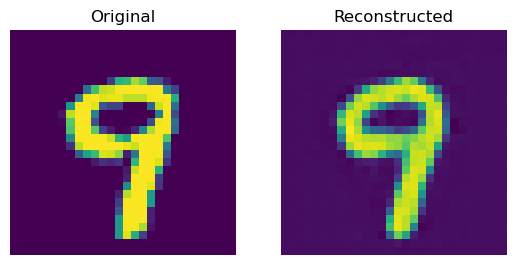

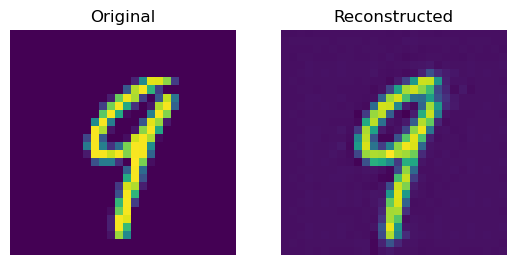

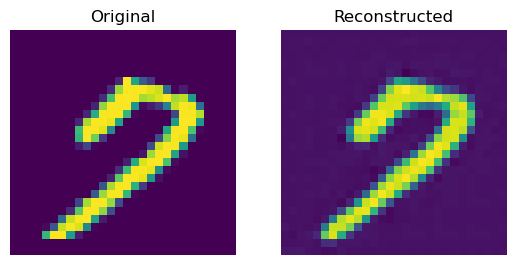

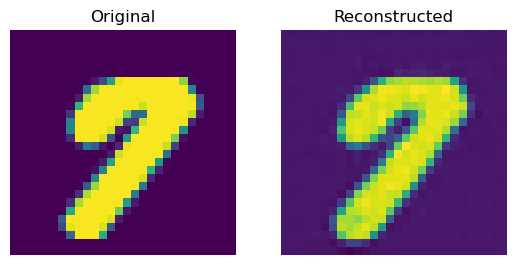

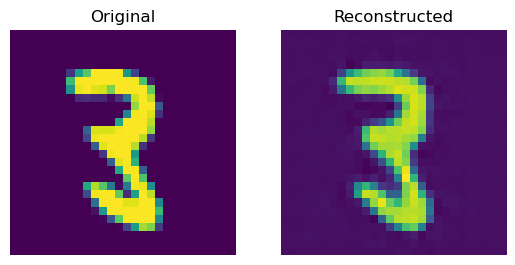

In [9]:
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)

1/1 [==============================] - 0s 149ms/step


2023-07-17 01:53:52.975486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


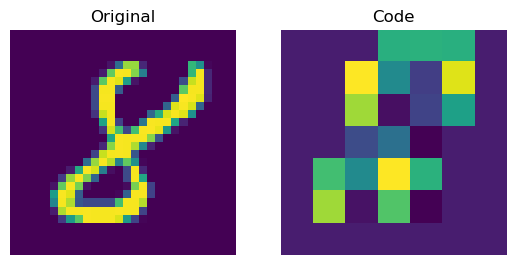

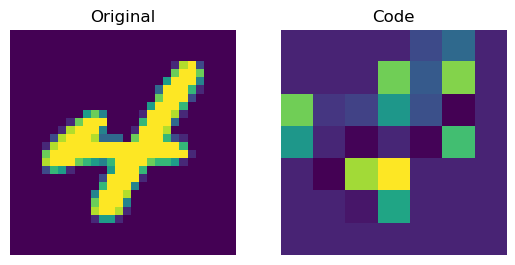

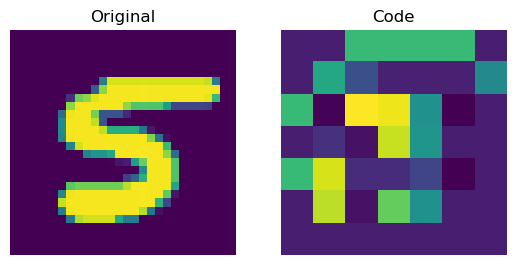

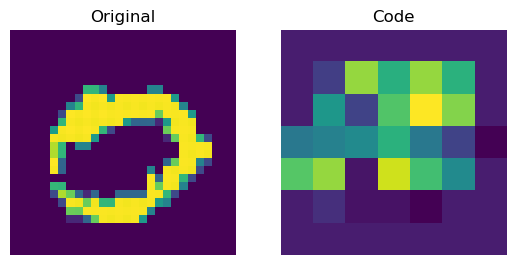

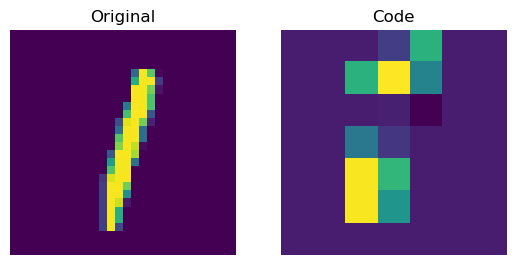

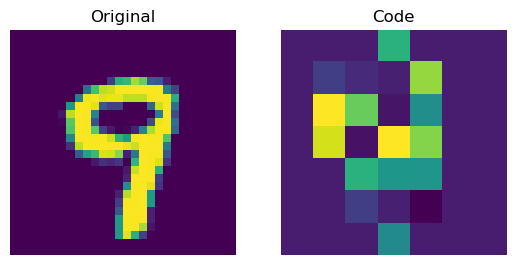

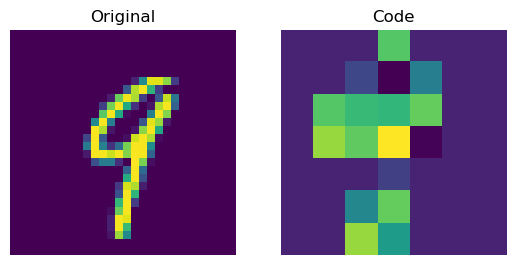

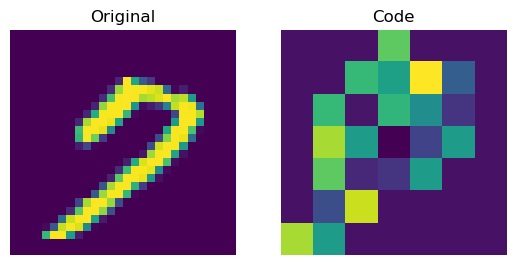

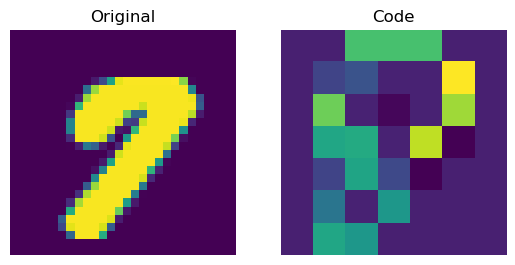

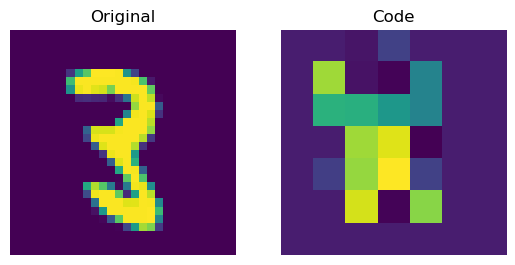

In [10]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()

In [12]:
encoded_outputs.shape

(10, 7, 7, 16)

In [11]:
num_residual_blocks = 2
num_pixelcnn_layers = 2
pixelcnn_input_shape = encoded_outputs.shape[1:-1]
print(f"Input shape of the PixelCNN: {pixelcnn_input_shape}")

Input shape of the PixelCNN: (7, 7)


In [13]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super().__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])


pixelcnn_inputs = keras.Input(shape=pixelcnn_input_shape, dtype=tf.int32)
ohe = tf.one_hot(pixelcnn_inputs, vqvae_trainer.num_embeddings)
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(ohe)

for _ in range(num_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(num_pixelcnn_layers):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv2D(
    filters=vqvae_trainer.num_embeddings, kernel_size=1, strides=1, padding="valid"
)(x)

pixel_cnn = keras.Model(pixelcnn_inputs, out, name="pixel_cnn")
pixel_cnn.summary()

Model: "pixel_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 7, 7)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, 7, 7, 128)         0         
                                                                 
 pixel_conv_layer (PixelCon  (None, 7, 7, 128)         802944    
 vLayer)                                                         
                                                                 
 residual_block (ResidualBl  (None, 7, 7, 128)         98624     
 ock)                                                            
                                                                 
 residual_block_1 (Residual  (None, 7, 7, 128)         98624     
 Block)                                                          
                                                         

In [14]:
# Generate the codebook indices.
encoded_outputs = encoder.predict(x_train_scaled)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)

codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
print(f"Shape of the training data for PixelCNN: {codebook_indices.shape}")

1875/1875 [==============================] - 3s 1ms/step
Shape of the training data for PixelCNN: (60000, 7, 7)


In [15]:
pixel_cnn.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
pixel_cnn.fit(
    x=codebook_indices,
    y=codebook_indices,
    batch_size=128,
    epochs=30,
    validation_split=0.1,
)

Epoch 1/30


2023-07-17 01:58:58.133837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


422/422 [==============================] - ETA: 0s - loss: 1.8375 - accuracy: 0.5947

2023-07-17 01:59:12.900299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


422/422 [==============================] - 16s 32ms/step - loss: 1.8375 - accuracy: 0.5947 - val_loss: 1.2936 - val_accuracy: 0.6296
Epoch 2/30
422/422 [==============================] - 12s 28ms/step - loss: 1.2241 - accuracy: 0.6406 - val_loss: 1.1878 - val_accuracy: 0.6459
Epoch 3/30
422/422 [==============================] - 12s 28ms/step - loss: 1.1569 - accuracy: 0.6522 - val_loss: 1.1503 - val_accuracy: 0.6525
Epoch 4/30
422/422 [==============================] - 12s 27ms/step - loss: 1.1209 - accuracy: 0.6587 - val_loss: 1.1209 - val_accuracy: 0.6580
Epoch 5/30
422/422 [==============================] - 12s 27ms/step - loss: 1.0961 - accuracy: 0.6635 - val_loss: 1.1056 - val_accuracy: 0.6606
Epoch 6/30
422/422 [==============================] - 12s 27ms/step - loss: 1.0787 - accuracy: 0.6667 - val_loss: 1.0965 - val_accuracy: 0.6615
Epoch 7/30
422/422 [==============================] - 12s 27ms/step - loss: 1.0650 - accuracy: 0.6695 - val_loss: 1.0885 - val_accuracy: 0.6634
Epo

In [16]:
# Create a mini sampler model.
inputs = layers.Input(shape=pixel_cnn.input_shape[1:])
outputs = pixel_cnn(inputs, training=False)
categorical_layer = tfp.layers.DistributionLambda(tfp.distributions.Categorical)
outputs = categorical_layer(outputs)
sampler = keras.Model(inputs, outputs)

In [17]:
# Create an empty array of priors.
batch = 10
priors = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols = priors.shape

# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in range(rows):
    for col in range(cols):
        # Feed the whole array and retrieving the pixel value probabilities for the next
        # pixel.
        probs = sampler.predict(priors)
        # Use the probabilities to pick pixel values and append the values to the priors.
        priors[:, row, col] = probs[:, row, col]

print(f"Prior shape: {priors.shape}")

2023-07-17 02:08:42.778892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 18ms/step
Prior shape: (10, 7, 7)


1/1 [==============================] - 0s 66ms/step


2023-07-17 02:10:12.049832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


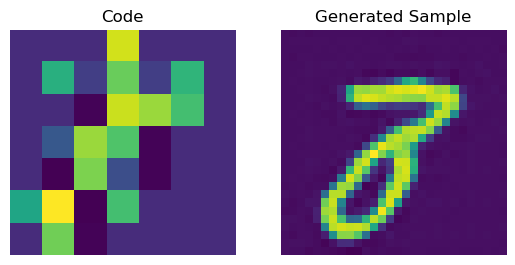

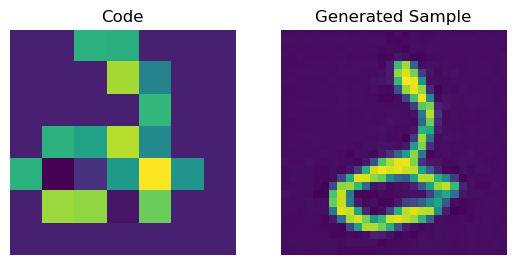

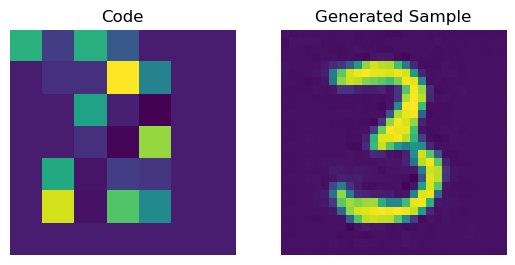

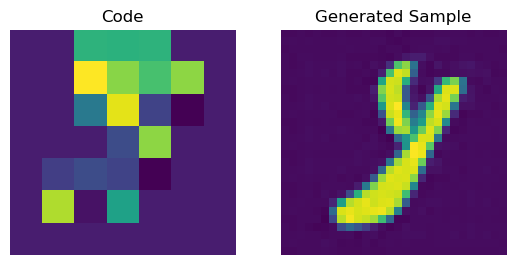

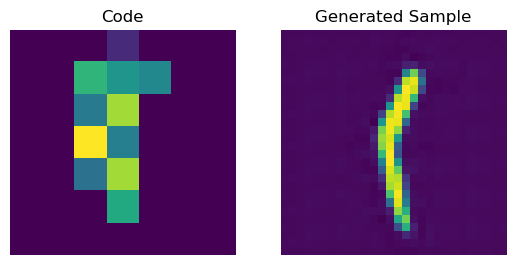

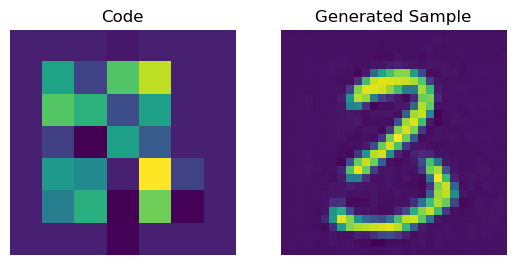

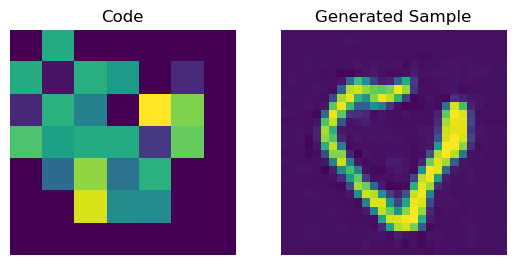

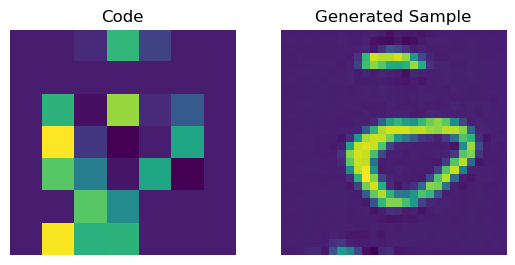

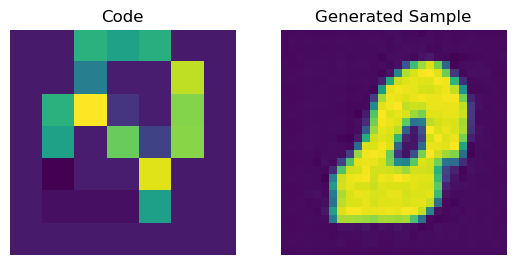

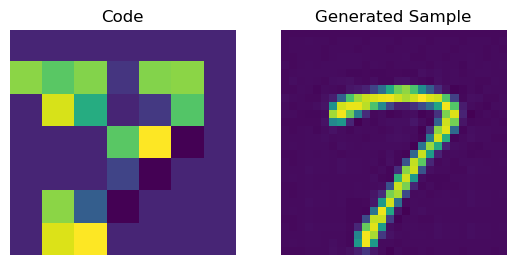

In [18]:
# Perform an embedding lookup.
pretrained_embeddings = quantizer.embeddings
priors_ohe = tf.one_hot(priors.astype("int32"), vqvae_trainer.num_embeddings).numpy()
quantized = tf.matmul(
    priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True
)
quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))

# Generate novel images.
decoder = vqvae_trainer.vqvae.get_layer("decoder")
generated_samples = decoder.predict(quantized)

for i in range(batch):
    plt.subplot(1, 2, 1)
    plt.imshow(priors[i])
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_samples[i].squeeze() + 0.5)
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()